In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/NBA_Player_Stats_2.csv'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(file_path)
print(df.head())

   Rk               Player Pos  Age   Tm   G  GS    MP   FG   FGA  ...  DRB  \
0   1   Mahmoud Abdul-Rauf  PG   28  SAC  31   0  17.1  3.3   8.8  ...  1.0   
1   2    Tariq Abdul-Wahad  SG   23  SAC  59  16  16.3  2.4   6.1  ...  1.2   
2   3  Shareef Abdur-Rahim  SF   21  VAN  82  82  36.0  8.0  16.4  ...  4.3   
3   4       Cory Alexander  PG   24  TOT  60  22  21.6  2.9   6.7  ...  2.2   
4   4       Cory Alexander  PG   24  SAS  37   3  13.5  1.6   3.9  ...  1.1   

   TRB  AST  STL  BLK  TOV   PF   PTS   Season    MVP  
0  1.2  1.9  0.5  0.0  0.6  1.0   7.3  1997-98  False  
1  2.0  0.9  0.6  0.2  1.1  1.4   6.4  1997-98  False  
2  7.1  2.6  1.1  0.9  3.1  2.5  22.3  1997-98  False  
3  2.4  3.5  1.2  0.2  1.9  1.6   8.1  1997-98  False  
4  1.3  1.9  0.7  0.1  1.3  1.4   4.5  1997-98  False  

[5 rows x 32 columns]


In [ ]:
num_rows = df.shape[0]
print(num_rows)

14573


In [ ]:
df.fillna(0, inplace = True)
nan_counts = df.isna().sum()
print(nan_counts)

Rk        0
Player    0
Pos       0
Age       0
Tm        0
G         0
GS        0
MP        0
FG        0
FGA       0
FG%       0
3P        0
3PA       0
3P%       0
2P        0
2PA       0
2P%       0
eFG%      0
FT        0
FTA       0
FT%       0
ORB       0
DRB       0
TRB       0
AST       0
STL       0
BLK       0
TOV       0
PF        0
PTS       0
Season    0
MVP       0
dtype: int64


In [ ]:
import pandas as pd
#Cleaning data in cases where a player switches teams mid-season.
#The dataset categorized these as two different rows and thus
#we needed to combine them to ensure the model trained properly.

tot_entries = df[df['Tm'] == 'TOT'][['Player', 'Season']]

mask = pd.merge(df, tot_entries, on=['Player', 'Season'], how='left', indicator=True)['_merge'] == 'left_only'

cleaned_df = df[(df['Tm'] == 'TOT') | mask]


player_avg_points = cleaned_df.groupby('Player')['PTS'].mean()

players_include = player_avg_points[player_avg_points >= 5].index

filtered_df = cleaned_df[cleaned_df['Player'].isin(players_include)]

filtered_df = cleaned_df[cleaned_df['PTS'] >= 5]

filtered_df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,MVP
0,1,Mahmoud Abdul-Rauf,PG,28,SAC,31,0,17.1,3.3,8.8,...,1.0,1.2,1.9,0.5,0.0,0.6,1.0,7.3,1997-98,False
1,2,Tariq Abdul-Wahad,SG,23,SAC,59,16,16.3,2.4,6.1,...,1.2,2.0,0.9,0.6,0.2,1.1,1.4,6.4,1997-98,False
2,3,Shareef Abdur-Rahim,SF,21,VAN,82,82,36.0,8.0,16.4,...,4.3,7.1,2.6,1.1,0.9,3.1,2.5,22.3,1997-98,False
3,4,Cory Alexander,PG,24,TOT,60,22,21.6,2.9,6.7,...,2.2,2.4,3.5,1.2,0.2,1.9,1.6,8.1,1997-98,False
6,5,Ray Allen*,SG,22,MIL,82,82,40.1,6.9,16.0,...,3.4,4.9,4.3,1.4,0.1,3.2,3.0,19.5,1997-98,False


In [ ]:
num_rows = cleaned_df.shape[0] #without players w multiple entries from being traded
print(num_rows)

11708


In [ ]:
num_rows = filtered_df.shape[0] #without players who averaged less than 5 in whole career
print(num_rows)

7404


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

feature_columns = ['G', 'GS', 'MP', 'FG', 'FGA','3P', '3PA','2P', '2PA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']


X = []
y = []

for player, group in filtered_df.groupby('Player'):
    # this is to ensure the sequence is in the correct order
    player_data = group.sort_values('Season')

    player_features = player_data[feature_columns].to_numpy()

    for i in range(len(player_features) - 1):
        X.append(player_features[:i+2])
        y.append(player_features[i+1])



X_padded = pad_sequences(X, padding='post', dtype='float32', value=0.0)
y = np.array(y)



In [ ]:
pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=c3660484e0f4e6629f099251deb2db83942782676003a08f7cb1c2057f3813fc
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention
num_features = X_padded.shape[2]
timesteps = X_padded.shape[1]

model = Sequential()

model.add(Masking(mask_value=0.0, input_shape=(timesteps, num_features)))

model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))  # adding a dropout layer for regularization purposes

model.add(SeqSelfAttention(attention_activation='sigmoid'))


model.add(LSTM(units=32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))  # even more dropout layer

model.add(Dense(units=len(feature_columns)))


model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 22, 18)            0         
                                                                 
 lstm (LSTM)                 (None, 22, 64)            21248     
                                                                 
 dropout (Dropout)           (None, 22, 64)            0         
                                                                 
 seq_self_attention (SeqSel  (None, 22, 64)            4161      
 fAttention)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [ ]:

X_train, X_val, X_test = [], [], []
y_train, y_val, y_test = [], [], []

current_index = 0

#essentially ensuring that we dont mess with the sequential order
#when splitting the data

for player, group in filtered_df.groupby('Player'):
    total_seasons = len(group) - 1

    train_end = int(total_seasons * 0.7)
    val_end = train_end + int(total_seasons * 0.15)

    player_X = X_padded[current_index:current_index + total_seasons]
    player_y = y[current_index:current_index + total_seasons]

    current_index += total_seasons

    X_train.extend(player_X[:train_end])
    y_train.extend(player_y[:train_end])

    X_val.extend(player_X[train_end:val_end])
    y_val.extend(player_y[train_end:val_end])

    X_test.extend(player_X[val_end:])
    y_test.extend(player_y[val_end:])


X_train = np.array(X_train, dtype='float32')
y_train = np.array(y_train, dtype='float32')

X_val = np.array(X_val, dtype='float32')
y_val = np.array(y_val, dtype='float32')

X_test = np.array(X_test, dtype='float32')
y_test = np.array(y_test, dtype='float32')


In [ ]:
print(X_padded.shape)


(5945, 22, 18)


In [ ]:

from tensorflow.keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1, restore_best_weights=True)
#we ended up neglecting early stopping because it produced much higher error than our chosen epoch number (165)

X_padded = X_padded.astype('float32')


y = y.astype('float32')

# training time
history = model.fit(
    X_train, y_train,
    epochs=165,
    batch_size=32,
    validation_data=(X_val, y_val),
    #callbacks=[early_stopping],
    verbose=1
)



Epoch 1/165
113/113 [==============================] - 16s 41ms/step - loss: 329.1215 - mae: 10.4274 - val_loss: 87.5397 - val_mae: 6.2793
Epoch 2/165
113/113 [==============================] - 6s 51ms/step - loss: 93.3637 - mae: 6.0721 - val_loss: 40.5295 - val_mae: 4.1531
Epoch 3/165
113/113 [==============================] - 4s 38ms/step - loss: 49.1742 - mae: 4.5402 - val_loss: 21.2785 - val_mae: 2.8256
Epoch 4/165
113/113 [==============================] - 4s 36ms/step - loss: 34.8553 - mae: 3.6727 - val_loss: 15.6925 - val_mae: 2.3787
Epoch 5/165
113/113 [==============================] - 6s 52ms/step - loss: 27.7267 - mae: 3.1886 - val_loss: 15.4469 - val_mae: 2.3100
Epoch 6/165
113/113 [==============================] - 4s 36ms/step - loss: 23.2529 - mae: 2.8484 - val_loss: 13.3635 - val_mae: 2.1536
Epoch 7/165
113/113 [==============================] - 4s 35ms/step - loss: 20.9835 - mae: 2.6436 - val_loss: 11.3364 - val_mae: 1.9739
Epoch 8/165
113/113 [========================

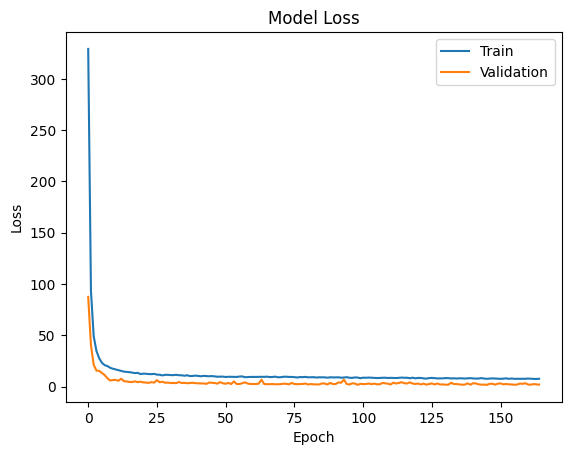

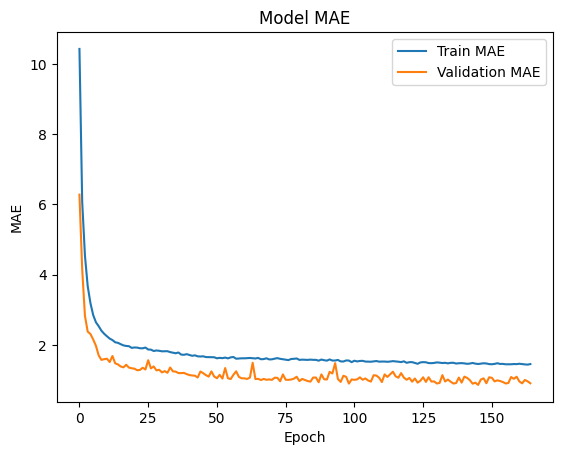

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

if 'mae' in history.history:
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()


In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


61/61 [==============================] - 1s 12ms/step - loss: 2.5160 - mae: 0.8668
Test Loss: 2.515990972518921, Test MAE: 0.8667515516281128


In [ ]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_val)
r2 = r2_score(y_val, y_pred)
print(f'R² score: {r2:.2f}')



13/13 [==============================] - 1s 11ms/step
R² score: 0.68


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    errors = np.where(y_true != 0, np.abs((y_true - y_pred) / y_true), 0)
    return np.mean(errors) * 100

y_pred = model.predict(X_val)
mape = mean_absolute_percentage_error(y_val, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


13/13 [==============================] - 0s 16ms/step
Mean Absolute Percentage Error (MAPE): 30.00%


<ipython-input-18-e679894eb201>:3: RuntimeWarning: divide by zero encountered in divide
  errors = np.where(y_true != 0, np.abs((y_true - y_pred) / y_true), 0)  # Ignore or handle zeros as needed


In [ ]:
#for testing on individual players
n = 4
player_data = filtered_df[(filtered_df['Player'] == 'Kyle Lowry')].sort_values('Season')[-n:]

player_sequence = player_data[feature_columns].to_numpy().reshape(1, n, -1)


#padding sequence to work for any length of season
player_sequence_padded = pad_sequences(player_sequence, maxlen=22, padding='post', dtype='float32', value=0.0)

prediction = model.predict(player_sequence_padded)


def calculate_percentage(makes, attempts):
    return makes / attempts if attempts > 0 else 0.0 #no div by zero

def format_and_align_predictions(prediction_array, feature_columns):
    predictions_dict = {feature: prediction for feature, prediction in zip(feature_columns, prediction_array.flatten())}

    fg_percentage = calculate_percentage(predictions_dict['FG'], predictions_dict['FGA'])
    three_p_percentage = calculate_percentage(predictions_dict['3P'], predictions_dict['3PA'])
    two_p_percentage = calculate_percentage(predictions_dict['2P'], predictions_dict['2PA'])


    format_str = "{:<25} {}"

    print(format_str.format("Feature", "Predicted Value"))
    print("-" * 40)


    for feature in feature_columns:
        formatted_value = f"{predictions_dict[feature]:.3f}"
        print(format_str.format(feature, formatted_value))

    print(format_str.format('FG%', f"{fg_percentage:.3f}"))  # adding fg%
    print(format_str.format('3P%', f"{three_p_percentage:.3f}"))
    print(format_str.format('2P%', f"{two_p_percentage:.3f}"))


format_and_align_predictions(prediction, feature_columns)







1/1 [==============================] - 0s 110ms/step
Feature                   Predicted Value
----------------------------------------
G                         63.849
GS                        62.799
MP                        33.054
FG                        4.419
FGA                       10.834
3P                        1.530
3PA                       4.267
2P                        2.907
2PA                       6.544
ORB                       0.769
DRB                       3.280
TRB                       4.029
AST                       4.122
STL                       1.202
BLK                       0.248
TOV                       1.898
PF                        2.170
PTS                       12.856
FG%                       0.408
3P%                       0.359
2P%                       0.444


In [ ]:
#https://www.kaggle.com/datasets/vivovinco/2023-2024-nba-player-stats/data.    2023 player stats